In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import mlflow
import mlflow.sklearn

# Read the training data
import os
train_file_path = os.getcwd() + '/house-prices-advanced-regression-techniques/train.csv'
test_file_path = os.getcwd() + '/house-prices-advanced-regression-techniques/test.csv'
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)


In [2]:
# Print shape of the data
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [3]:
y = train_data.SalePrice

Check for missing values

In [33]:
# View the features with NaN values more than 50%
Total_samples = train_data.shape[0]
features_with_null_in_train = train_data.columns[train_data.isnull().sum()/Total_samples > 0.5]
features_with_null_in_test = test_data.columns[test_data.isnull().sum()/Total_samples > 0.5]
print('# of features with null values more than 50% in training data :', len(features_with_null_in_train))
print('Features with null values more than 50% in training data :', *features_with_null_in_train,sep='\n')
print('\n\n')
print('# of features with null values more than 50% in test data :', len(features_with_null_in_test))
print('Features with null values more than 50% in test data :', *features_with_null_in_test,sep='\n')

# of features with null values more than 50% in training data : 4
Features with null values more than 50% in training data :
Alley
PoolQC
Fence
MiscFeature



# of features with null values more than 50% in test data : 4
Features with null values more than 50% in test data :
Alley
PoolQC
Fence
MiscFeature


In [36]:
# Combine lists of features that contain null values.
features_with_null = list(features_with_null_in_test.copy())
for feature in features_with_null_in_train:
    if feature not in features_with_null_in_test.copy():
        features_with_null.append(feature)
    
print('# of features containing null values :', len(features_with_null))

print('Features containing null values :', *features_with_null, sep = '\n')

# of features containing null values : 4
Features containing null values :
Alley
PoolQC
Fence
MiscFeature


Impute training data and test data. Numeric features will be imputed by "mean" while categorical features will be imputed by "mode" value.

In [97]:
# Drop the features with NaN values more than 50%
# reduced_train_data = train_data[train_data.columns[train_data.isnull().sum()/Total_samples < 0.5]]
# reduced_test_data = train_data[test_data.columns[test_data.isnull().sum()/Total_samples < 0.5]]

reduced_train_data = train_data.copy()
reduced_test_data = test_data.copy()
for col in features_with_null:
    reduced_train_data.pop(col)
    reduced_test_data.pop(col)



In [98]:
# Select training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_data, y, train_size=0.8,
                                                      test_size=0.2, random_state=12345)
X_test = test_data.copy()

# Select reduced training and validation sets
X_train_reduced, X_valid_reduced, _, _ = train_test_split(reduced_train_data, y, train_size=0.8,
                                                      test_size=0.2, random_state=12345)
X_test_reduced = reduced_test_data.copy()

from sklearn.impute import SimpleImputer
my_numeric_imputer = SimpleImputer()
my_categorical_imputer = SimpleImputer(strategy = 'most_frequent')

In [99]:
# Impute original datasets
imputed_X_train = X_train.copy()
imputed_X_valid = X_valid.copy()
imputed_X_test = X_test.copy()

for label,_ in imputed_X_test.items():
    if imputed_X_train[label].dtype == 'object':
        imputed_X_train[label].fillna(imputed_X_train[label].mode()[0], inplace = True)
        imputed_X_valid[label].fillna(imputed_X_train[label].mode()[0], inplace = True)
        imputed_X_test[label].fillna(imputed_X_train[label].mode()[0], inplace = True)
    else:
        imputed_X_train[label].fillna(imputed_X_train[label].mean(), inplace = True)
        imputed_X_valid[label].fillna(imputed_X_train[label].mean(), inplace = True)
        imputed_X_test[label].fillna(imputed_X_train[label].mean(), inplace = True)

# Impute reduced datasets
imputed_X_train_reduced = X_train_reduced.copy()
imputed_X_valid_reduced = X_valid_reduced.copy()
imputed_X_test_reduced = X_test_reduced.copy()

for label,_ in imputed_X_test_reduced.items():
    if imputed_X_train_reduced[label].dtype == 'object':
        imputed_X_train_reduced[label].fillna(imputed_X_train_reduced[label].mode()[0], inplace = True)
        imputed_X_valid_reduced[label].fillna(imputed_X_train_reduced[label].mode()[0], inplace = True)
        imputed_X_test_reduced[label].fillna(imputed_X_train_reduced[label].mode()[0], inplace = True)
    else:
        imputed_X_train_reduced[label].fillna(imputed_X_train_reduced[label].mean(), inplace = True)
        imputed_X_valid_reduced[label].fillna(imputed_X_train_reduced[label].mean(), inplace = True)
        imputed_X_test_reduced[label].fillna(imputed_X_train_reduced[label].mean(), inplace = True)

In [142]:
from sklearn.preprocessing import OrdinalEncoder
# Get list of categorical variables
s_full = (imputed_X_train.dtypes == 'object')
object_cols_full = list(s_full[s_full].index)

s_reduced = (imputed_X_train_reduced.dtypes == 'object')
object_cols_reduced = list(s_reduced[s_reduced].index)

# Make copy to avoid changing original data 
label_X_train = imputed_X_train.copy()
label_X_valid = imputed_X_valid.copy()
label_X_test = imputed_X_test.copy()

label_X_train_reduced = imputed_X_train_reduced.copy()
label_X_valid_reduced = imputed_X_valid_reduced.copy()
label_X_test_reduced = imputed_X_test_reduced.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
label_X_train[object_cols_full] = ordinal_encoder.fit_transform(imputed_X_train[object_cols_full])
label_X_valid[object_cols_full] = ordinal_encoder.transform(imputed_X_valid[object_cols_full])
label_X_test[object_cols_full] = ordinal_encoder.transform(imputed_X_test[object_cols_full])

ordinal_encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)
label_X_train_reduced[object_cols_reduced] = ordinal_encoder.fit_transform(imputed_X_train_reduced[object_cols_reduced])
label_X_valid_reduced[object_cols_reduced] = ordinal_encoder.transform(imputed_X_valid_reduced[object_cols_reduced])
label_X_test_reduced[object_cols_reduced] = ordinal_encoder.transform(imputed_X_test_reduced[object_cols_reduced])


Now look at correlation matrix

In [169]:
# Select features with highest correlations
corr = imputed_X_train.corr(method = 'pearson')
highest_corr_features_07 = corr.index[abs(corr['SalePrice']) > 0.7].drop('SalePrice')
highest_corr_features_05 = corr.index[abs(corr['SalePrice']) > 0.5].drop('SalePrice')
highest_corr_features_03 = corr.index[abs(corr['SalePrice']) > 0.3].drop('SalePrice')
highest_corr_features_01 = corr.index[abs(corr['SalePrice']) > 0.1].drop('SalePrice')

#highest_corr_features_07 = highest_corr_features_07.drop('SalePrice')
#highest_corr_features_05 = highest_corr_features_05.drop('SalePrice')
#highest_corr_features_03 = highest_corr_features_03.drop('SalePrice')
#highest_corr_features_01 = highest_corr_features_01.drop('SalePrice')

C:\Users\adems\AppData\Local\Temp\ipykernel_1324\2737684417.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = imputed_X_train.corr(method = 'pearson')


C:\Users\adems\AppData\Local\Temp\ipykernel_1324\408176140.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = imputed_X_train.corr(method = 'pearson')


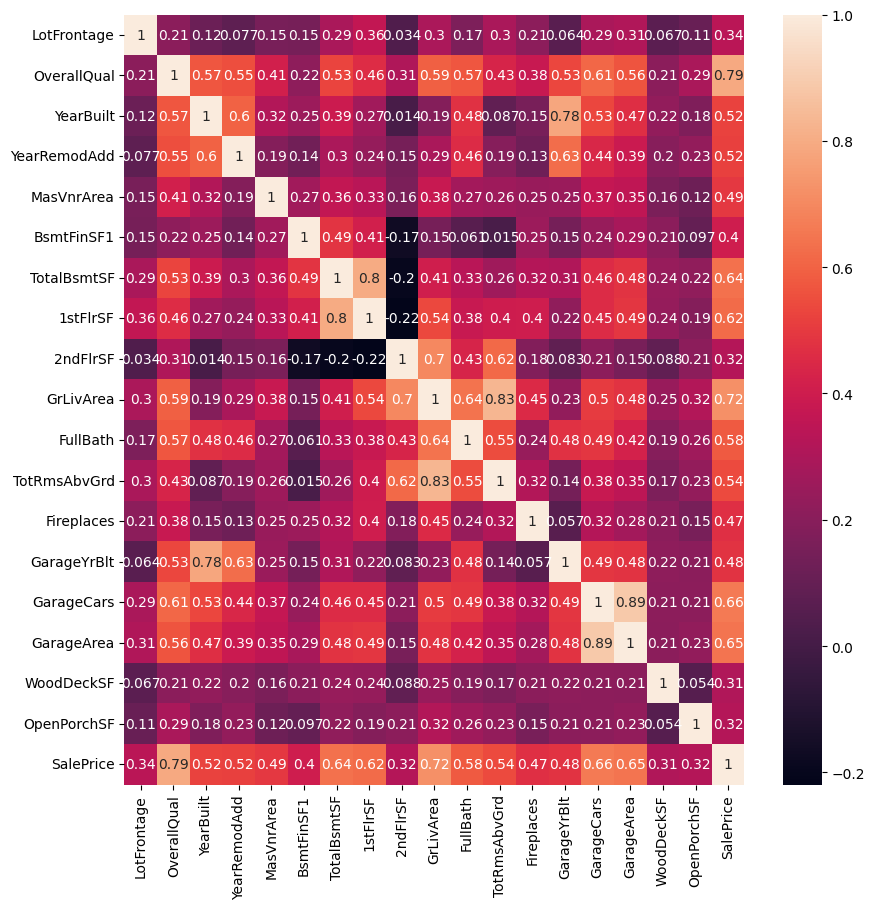

In [76]:
corr = imputed_X_train.corr(method = 'pearson')
highest_corr_features = corr.index[abs(corr['SalePrice']) > 0.3]
fig = plt.figure(figsize = (10,10))
g = sns.heatmap(imputed_X_train[highest_corr_features].corr(), annot = True)

Sort the correlation matrix to see the features that are most related to 'SalePrice'

In [170]:
reduced_label_X_train_07 = label_X_train[highest_corr_features_07]
reduced_label_X_test_07 = label_X_test[highest_corr_features_07]
reduced_label_X_valid_07 = label_X_valid[highest_corr_features_07]

reduced_label_X_train_05 = label_X_train[highest_corr_features_05]
reduced_label_X_test_05 = label_X_test[highest_corr_features_05]
reduced_label_X_valid_05 = label_X_valid[highest_corr_features_05]

reduced_label_X_train_03 = label_X_train[highest_corr_features_03]
reduced_label_X_test_03 = label_X_test[highest_corr_features_03]
reduced_label_X_valid_03 = label_X_valid[highest_corr_features_03]

reduced_label_X_train_01 = label_X_train[highest_corr_features_01]
reduced_label_X_test_01 = label_X_test[highest_corr_features_01]
reduced_label_X_valid_01 = label_X_valid[highest_corr_features_01]


Apply ML Model

In [ ]:
mlflow.autolog()

In [179]:
from sklearn.ensemble import RandomForestRegressor

mlflow.sklearn.autolog()

RF_07 = RandomForestRegressor(bootstrap = True, random_state = 12345)
RF_05 = RandomForestRegressor(bootstrap = True, random_state = 12345)
RF_03 = RandomForestRegressor(bootstrap = True, random_state = 12345)
RF_01 = RandomForestRegressor(bootstrap = True, random_state = 12345)

RF_07.fit(reduced_label_X_train_07, y_train)
y_predict_07 = RF_07.predict(reduced_label_X_valid_07)

RF_05.fit(reduced_label_X_train_05, y_train)
y_predict_05 = RF_05.predict(reduced_label_X_valid_05)

RF_03.fit(reduced_label_X_train_03, y_train)
y_predict_03 = RF_03.predict(reduced_label_X_valid_03)

RF_01.fit(reduced_label_X_train_01, y_train)
y_predict_01 = RF_01.predict(reduced_label_X_valid_01)

2022/12/05 09:47:59 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: [WinError 5] Erişim engellendi: 'C:\\Users\\90543\\Drive\\YAP470-BIL570\\Project\\Jupy\\mlruns\\0\\608382dacdd84ba48248347b680b2325'
2022/12/05 09:48:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: [WinError 5] Erişim engellendi: 'C:\\Users\\90543\\Drive\\YAP470-BIL570\\Project\\Jupy\\mlruns\\0\\608382dacdd84ba48248347b680b2325'
2022/12/05 09:48:02 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: [WinError 5] Erişim engellendi: 'C:\\Users\\90543\\Drive\\YAP470-BIL570\\Project\\Jupy\\mlruns\\0\\608382dacdd84ba48248347b680b2325'
2022/12/05 09:48:03 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: [WinError 5] Erişim engellendi: 'C:\\Users\\90543\\Drive\\YAP470-BIL570\\Project\\Jupy\\mlruns\\0\\608382dacdd84ba48248347b680b2325'


In [181]:
from sklearn.metrics import mean_absolute_error
mae_07 = mean_absolute_error(y_predict_07, y_valid)
mae_05 = mean_absolute_error(y_predict_05, y_valid)
mae_03 = mean_absolute_error(y_predict_03, y_valid)
mae_01 = mean_absolute_error(y_predict_01, y_valid)

print("Mean Absolute Error with 0.7 correlation threshold : ", mae_07)
print("Mean Absolute Error with 0.5 correlation threshold : ", mae_05)
print("Mean Absolute Error with 0.3 correlation threshold : ",mae_03)
print("Mean Absolute Error with 0.1 correlation threshold : ",mae_01)
mlflow.log_metric('mea with featrues greater than 0.7 correlation', mae_07)
mlflow.log_metric('mea with featrues greater than 0.5 correlation', mae_05)
mlflow.log_metric('mea with featrues greater than 0.3 correlation', mae_03)
mlflow.log_metric('mea with featrues greater than 0.3 correlation', mae_01)

Mean Absolute Error with 0.7 correlation threshold :  26893.14936170964
Mean Absolute Error with 0.5 correlation threshold :  19303.57306536747
Mean Absolute Error with 0.3 correlation threshold :  18235.914424331375
Mean Absolute Error with 0.1 correlation threshold :  17834.8437716895


In [182]:
mlflow.end_run()